In [24]:
!pip install numpy pandas matplotlib scikit-learn tensorflow

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
# Load stock data
symbol = 'AAPL'  # Example stock: Apple
stock_data = yf.download(symbol, start='2020-01-01', end='2024-01-01')



[*********************100%***********************]  1 of 1 completed


In [3]:
df=pd.read_csv("/content/AAPL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [25]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [26]:
# Sort by date (if not already sorted)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [27]:
# Use only the 'Close' column
data = df['Close'].values
data = data.reshape(-1, 1)


In [28]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)



In [29]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [30]:
# Create sequences of 60 days for training/testing
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [31]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - loss: 2.3206e-04 - val_loss: 0.0010
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 7.1004e-06 - val_loss: 3.7225e-04
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - loss: 7.5023e-06 - val_loss: 3.6258e-04
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - loss: 6.3181e-06 - val_loss: 3.4715e-04
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 7.3844e-06 - val_loss: 7.3331e-04
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 7.7005e-06 - val_loss: 0.0019
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 1.2334e-05 - val_loss: 2.3317e-04
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 4.6615e-06 - val_loss: 3.7112e-04
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 4.2302e-06 - val_loss: 2.4325e-04
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 4.9567e-06 - val_loss: 2.8499e-04


In [34]:
# Predict and inverse the scaling
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual test values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


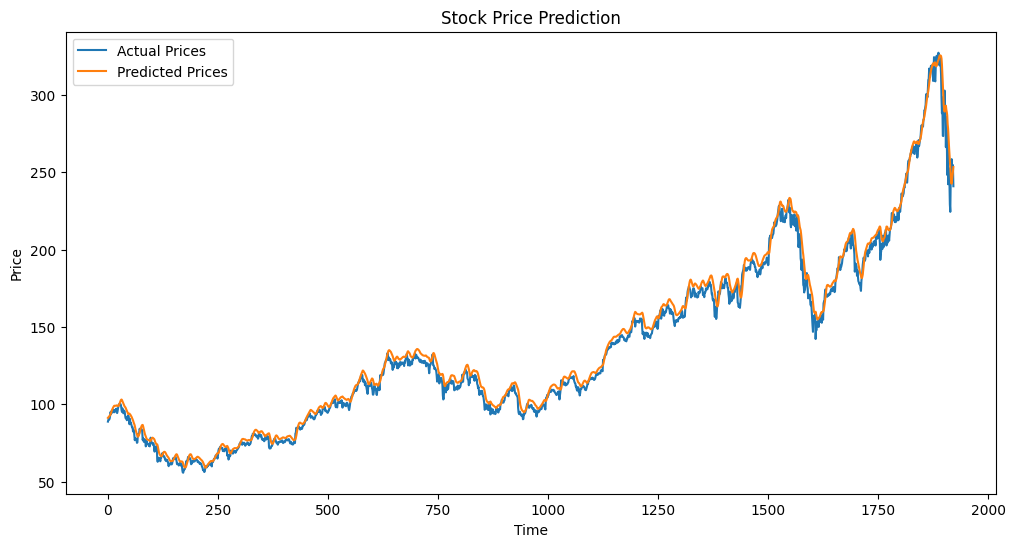

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [4]:
# Feature Engineering: Calculate daily changes and moving averages
stock_data['Price Change'] = stock_data['Close'].pct_change()
stock_data['5 Day MA'] = stock_data['Close'].rolling(window=5).mean()
stock_data['10 Day MA'] = stock_data['Close'].rolling(window=10).mean()


In [5]:
# Remove NaN values after feature creation
stock_data = stock_data.dropna()




In [6]:
# Define target: classify if the next day's price will go up or down
stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)


In [7]:
# Drop the last row due to NaN target
stock_data = stock_data[:-1]


In [8]:
# Features and target selection
features = stock_data[['Price Change', '5 Day MA', '10 Day MA']]
X = features.values
y = stock_data['Target'].values


In [9]:
# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [11]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)


In [12]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)


In [13]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)


In [14]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [15]:
# Evaluate models
def evaluate_model(predictions, model_name):
  print(f"{model_name} Performance")
  print("Accuracy:", accuracy_score(y_test, predictions))
  print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
  print("Classification Report:\n", classification_report(y_test, predictions))
  print("---------------------------")


In [16]:
print("Stock Price Prediction Results:\n")


Stock Price Prediction Results:



In [17]:
# Naive Bayes Evaluation
evaluate_model(nb_pred, "Naive Bayes")

# KNN Evaluation
evaluate_model(knn_pred, "K-Nearest Neighbors")

# Decision Tree Evaluation
evaluate_model(dt_pred, "Decision Tree")

# Random Forest Evaluation
evaluate_model(rf_pred, "Random Forest")


Naive Bayes Performance
Accuracy: 0.48
Confusion Matrix:
 [[33 55]
 [49 63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.38      0.39        88
           1       0.53      0.56      0.55       112

    accuracy                           0.48       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.48      0.48      0.48       200

---------------------------
K-Nearest Neighbors Performance
Accuracy: 0.465
Confusion Matrix:
 [[35 53]
 [54 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.40      0.40        88
           1       0.52      0.52      0.52       112

    accuracy                           0.47       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.47      0.47      0.47       200

---------------------------
Decision Tree Performance
Accuracy: 0.495
Confusion Matrix:
 [[34 54]
 [47 65]]